# CHAPTER 7 RNN을 사용한 문장 생성

## 7.1 언어 모델을 사용한 문장 생성

### 7.1.1 RNN을 사용한 문장 생성의 순서

<img src='./img/7/Rnnlm_1.png' width=700>

언어 모델은 지금까지 주어진 단어들에서 다음에 출현하는 단어의 확률분포를 출력함  
  
확률분포를 기초로 다음 단어를 새로 생성하는 방법은 다음 두 가지 방법이 있음  
  
1. 확률이 가장 높은 단어를 선택하는 방법, 결과가 일정하게 정해지는 '결정적(deterministic)'인 방법  
  
2. '확률적(probabilistic)'으로 선택하는 방법, 각 후보 단어의 확률에 맞게 선택, 선택되는 단어(샘플링 단어)가 매번 다를 수 있음  
  
위의 예시처럼 언어 모델은 확률분포 출력과 이를 기초로 다음 단어를 생성하고,  
새로 생성한 단어를 언어 모델에 입력하여 다음 단어의 확률 분포를 얻어 또 새로운 단어를 예측하는 과정을 반복하여(종결 기호가 나타날 때까지)  
새로운 문장을 생성함  
  
여기서 생성한 문장은 훈련 데이터에서 사용된 단어의 정렬 패턴을 학습하여 생성한 새로운 문장이다.

### 7.1.2 문장 생성 구현

문장을 생성하는 코드 구현  
  
- RnnlmGen 클래스  
  
6장에서 구현한 Rnnlm 클래스를 상속받고, 문장 생성 메서드를 추가함  
단어 생성 방법은 '확률적' 선택 방법을 적용함
  
- generate 메서드  
    인수목록
    - start_id : 최초로 주는 단어의 ID
    - skip_ids : 샘플링되지 않도록 정해놓은 단어들의 ID
    - sample_size  

In [1]:
from common.functions import softmax
from ch06.rnnlm import Rnnlm
from ch06.better_rnnlm import BetterRnnlm

class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x) # 각 단어의 점수 출력
            p = softmax(score.flatten()) # 정규화

            sampled = np.random.choice(len(p), size=1, p=p) # 확률분포 p로부터 다음 단어 샘플링
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

    def get_state(self):
        return self.lstm_layer.h, self.lstm_layer.c

    def set_state(self, state):
        self.lstm_layer.set_state(*state)

학습을 수행하지 않은 상태(가중치 매개변수가 무작위 초깃값인 상태)에서 문장 생성

In [5]:
from dataset import ptb
import numpy as np

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()

# start 문자와 skip 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you favors chiron finances feel thick fine dictator in teagan available setting fournier needed yet wholesale inland studying convicted tale squeeze backlash chase ski bar manipulation rallied short-lived reverse landscape clear payroll criticized ronald unauthorized ever misses rich rubbermaid analyst four-day nonprofit predicts free its interior worth rubble heels exercises providing scared locally republics french pretoria bought risks whiskey murphy negotiation facility keep at&t punts policy criticisms beer seasonal successes unhappy brazil crimes defects hiroshima feared guarantee bill easing gorbachev mass. acquire aircraft tree advocates wanted diaper walter workplace continent topple opens bed offensive faster furukawa ethnic adds penny sure


6장에서 학습한 가중치 매개변수를 사용하여 문장 생성

In [8]:
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params('ch06/Rnnlm.pkl') # 6장에서 저장한 가중치 사용

# start 문자와 skip 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you know mr. roman 's measure.
 the northern california states panel rushed to take three days instead of barred from the extract of the saul coast longer prohibit wisconsin music and really parks to the true level mr. lawson struggles.
 much of mr. honecker tell he away into coup s.p.
 the soviet leaders have viewed right security says dr..
 his car lawyer james c. morris a longtime aide to reduce tuition management on the last time.
 he also anticipates tried to the potential in a takeover battle with it.
 the diversity of u.n. cook


### 7.1.3 더 좋은 문장으로

문장을 생성하는 코드 구현  
  
- BetterRnnlmGen 클래스  
  
6장에서 구현한 BetterRnnlm 클래스를 상속받고, 문장 생성 메서드를 추가함  
단어 생성 방법은 '확률적' 선택 방법을 적용함

In [9]:
class BetterRnnlmGen(BetterRnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x).flatten()
            p = softmax(score).flatten()

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

    def get_state(self):
        states = []
        for layer in self.lstm_layers:
            states.append((layer.h, layer.c))
        return states

    def set_state(self, states):
        for layer, state in zip(self.lstm_layers, states):
            layer.set_state(*state)

In [12]:
from common.np import *
from dataset import ptb
import numpy as np

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)


model = BetterRnnlmGen()
model.load_params('ch06/BetterRnnlm.pkl') # 6장에서 저장한 가중치 사용

# start 문자와 skip 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you had n't survived.
 mr. hahn 's wife said he is were quietly looking for ways to keep money dressed at first rate fares to work as foreign naval agencies.
 but he says the amount of new financial partners needed for the deal it is too heavy for confusion.
 the poles say to remain for with banks and rights thus could possible markets that money owners are able to spur protection from their competing properties.
 he said interpublic has agreed to change privatization in its early 1970s next month has modest foreign flexibility.
 japan 's


"the meaning of life is"라는 글을 주고 이어지는 말 생성

In [20]:
model.reset_state()

start_words = 'the meaning of life is'
start_ids = [word_to_id[w] for w in start_words.split(' ')]

for x in start_ids[:-1]:
    x = np.array(x).reshape(1, 1)
    model.predict(x)

word_ids = model.generate(start_ids[-1], skip_ids)
word_ids = start_ids[:-1] + word_ids
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

the meaning of life is a presidential candidate for major opposition among the things who they make organizations such as a burgess tested in mexico 's khmer rouge traffic.
 on substance then and forth of looks a private costly showing on the table we 're the woman 's picket line and a model on that 1970s.
 people always doubt they should have to encourage us to put and thought in the people to become running seasons across the middle.
 but there 's only just a month through the second time or so blacks initially played it alive.
 strong efforts to


## 7.2 seq2seq

seq2seq(sequence to sequence)  
: 2개의 RNN을 이용하여 시계열 데이터를 다른 시계열 데이터로 변환하는 모델(입력과 출력이 시계열 데이터)

### 7.2.1 seq2seq의 원리

seq2seq 모델을 Encoder-Decoder 모델이라고도 함  
이름 그대로 Encoder는 입력 데이터를 인코딩하고, Decoder는 인코딩된 데이터를 디코딩함  

<img src='./img/7/seq2seq_1.png' width=300>

위의 예시와 같이, "나는 고양이로소이다"라는 문장을 "I am a cat"으로 번역을 하면, 다음과 같은 과정을 거침
  
그림에서와 같이 Encoder가 "나는 고양이로소이다"라는 출발어 문장을 인코딩한다.  
이 때 인코딩 정보에는 번역에 필요한 정보가 응축되어 있음  
이어서 인코딩한 정보를 Decoder에 넘겨주고,  
Decoder는 이 정보를 바탕으로 도착어 문장을 생성함  
  
__Encoder__  
  
<img src='./img/7/encoder_1.png' width=700>  
  
Encoder는 RNN을 이용해 시계열 데이터를 h라는 은닉 상태 벡터로 변환함  
(RNN으로 LSTM을 사용한다고 가정)
Encoder가 출력하는 벡터 h는 LSTM 계층의 마지막 은닉상태이며, 입력 문장(출발어)을 번역하는데 필요한 정보가 인코딩 됨  
  
<img src='./img/7/encoder_2.png' width=600>  
  
또한, LSTM의 은닉 상태 h는 임의 길이의 문장에서 고정 길이 벡터로 변환됨  
  
__Decoder__  
  
<img src='./img/7/decoder_1.png' width=700>  
  
Decoder는 LSTM 계층이 벡터 h를 입력받는다는 점을 제외하고는 기존에 구현했던 신경망과 같은 구조임  
  
__seq2seq__  
  
<img src='./img/7/seq2seq_2.png' width=800>  
  
seq2seq 모델의 전체적인 구조를 보면 LSTM 두 개(Encoder의 LSTM과 Decoder의 LSTM)로 구성됨  
이때 LSTM 계층의 은닉 상태가 Encoder와 Decoder를 이어줌  
  
순전파 때 Encoder에서 인코딩된 정보가 LSTM 계층의 은닉 상태를 통해 Decoder로 전해지고,  
역전파 때 이 은닉 상태를 통해 기울기가 Decode로부터 Encoder로 전해짐

### 7.2.2 시계열 데이터 변환용 장난감 문제

< 참고 > 머신러닝을 평가하고자 만든 간단한 문제를 '장난감 문제(toy problem)'라고 함  
  
<img src='./img/7/toy_problem_1.png' width=400>  
  
이번에는 단어 단위가 아닌 문자 단위로 분할하여 위의 그림처럼 '더하기'를 하는 seq2seq를 구현

### 7.2.3 가변 길이 시계열 데이터

이 '덧셈' 문제에서는 샘플마다 데이터의 시간 방향 크기가 다른 '가변 길이 시계열 데이터'를 다룸  
  
미니배치로 학습할 때는 다수의 샘플을 한꺼번에 처리하므로, 한 미니배치에 속한 샘플들의 데이터 형상이 모두 같아야 함  
  
가변 길이 시계열 데이터를 미니배치로 학습하기 위한 방법으로 __패딩(padding)__을 사용  
패딩이란 원래의 데이터에 의미 없는 데이터를 채워 모든 데이터의 길이를 균일하게 맞추는 기법  
  
<img src='./img/7/padding.png' width=500>  
    
입력 데이터와 정답 데이터 모두 패딩을 수행해 각각 샘플 데이터의 길이를 통일시켜야 함  
또한, 질문과 정답을 구분하기 위해 출력 앞에 구분자를 붙임
이 구분자는 Decoder에 문자열을 생성하라고 알리는 신호로 사용됨
  
패딩을 적용해야 하지만 정확성이 중요하다면 seq2seq에 패딩 전용 처리를 추가해야 함  
Decoder에 입력된 데이터가 패딩이라면 손실의 결과에 반영하지 않도록 하여야 하고,  
(Softmax with Loss 계층에 '마스크'기능을 추가해 해결할 수 있음)  
Encoder에 입력된 데이터가 패딩이라면 LSTM 계층이 이전 시각의 입력을 그대로 출력하게 해야 함
  
이 예제에서는 0~999 사이의 숫자 2개만 더하는 문제로, '+'까지 포함하면 입력 데이터의 최대 문자 수는 7, 정답 데이터의 최대 문자 수는 4가 됨  
남는 공간에는 의미 없는 데이터(여기서는 '공백')을 채우고,  
구분자로 '\_'을 사용함  

### 7.2.4 덧셈 데이터셋

In [21]:
import os
import numpy


id_to_char = {}
char_to_id = {}


def _update_vocab(txt):
    chars = list(txt)

    for i, char in enumerate(chars):
        if char not in char_to_id:
            tmp_id = len(char_to_id)
            char_to_id[char] = tmp_id
            id_to_char[tmp_id] = char


def load_data(file_name='addition.txt', seed=1984):
    file_path = os.path.dirname(os.path.abspath(__file__)) + '/' + file_name

    if not os.path.exists(file_path):
        print('No file: %s' % file_name)
        return None

    questions, answers = [], []

    for line in open(file_path, 'r'):
        idx = line.find('_')
        questions.append(line[:idx])
        answers.append(line[idx:-1])

    # 어휘 사전 생성
    for i in range(len(questions)):
        q, a = questions[i], answers[i]
        _update_vocab(q)
        _update_vocab(a)

    # 넘파이 배열 생성
    x = numpy.zeros((len(questions), len(questions[0])), dtype=numpy.int)
    t = numpy.zeros((len(questions), len(answers[0])), dtype=numpy.int)

    for i, sentence in enumerate(questions):
        x[i] = [char_to_id[c] for c in list(sentence)]
    for i, sentence in enumerate(answers):
        t[i] = [char_to_id[c] for c in list(sentence)]

    # 뒤섞기
    indices = numpy.arange(len(x))
    if seed is not None:
        numpy.random.seed(seed)
    numpy.random.shuffle(indices)
    x = x[indices]
    t = t[indices]

    # 검증 데이터셋으로 10% 할당
    split_at = len(x) - len(x) // 10
    (x_train, x_test) = x[:split_at], x[split_at:]
    (t_train, t_test) = t[:split_at], t[split_at:]

    return (x_train, t_train), (x_test, t_test)


def get_vocab():
    return char_to_id, id_to_char

In [26]:
from dataset import sequence

(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('addition.txt', seed=1984)
char_to_id, id_to_char = sequence.get_vocab()

print(x_train[1])
print(t_train[1])

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))

[ 4  0  9  2  8  8 10]
[ 6  3 10 10  5]
71+118 
_189 


## 7.3 seq2seq 구현

### 7.3.1 Encoder 클래스

<img src='./img/7/encoder_3.png' width=800>  

- Encoder 클래스  
  
    Embedding 계층과 LSTM 계층으로 구성됨  
    * Embedding 계층 : 문자 ID를 문자 벡터로 변환함  
    * LSTM 계층 : 시간 방향(오른쪽)으로 은닉 상태와 셀을 출력하고 위쪽으로는 은닉 상태만 출력  
        이 구성에서 더 위에는 다른 꼐층이 없으므로 LSTM 계층의 위쪽 출력은 폐기됨  

Encoder에서는 마지막 문자를 처리한 후 LSTM 계층의 은닉 상태 h를 출력하며,  
이 은닉 상태 h는 Decoder로 전달됨

In [28]:
class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size): # vocab_size는 어휘 수(문자의 종류 수)  
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4*H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)
        
        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None
        
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]
    
    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh
        
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

### 7.3.2 Decoder 클래스

RNN으로 문장을 생성할 때, 학습 시와 생성 시의 데이터 부여 방법이 다름  
학습 시는 정답을 알고 있기 때문에 시계열 방향의 데이터를 한 번에 줄 수 있으나,  
추론 시(새로운 문자열을 생성)에는 최초 시작을 알리는 구분자 하나만 주고  
그 출력으로 부터 문자를 하나 샘플링하여, 샘플링한 문자를 다음 입력으로 사용하는 과정을 반복함  
  
<img src='./img/7/decoder_2.png' width=600>  
  
Decoder의 학습 시 계층 구성

<img src='./img/7/decoder_3.png' width=600>  

Decoder의 문자열 생성 순서  
  
'argmax' 노드는 최댓값을 가진 원소의 인덱스(이번 예에서는 문자 ID)를 선택하는 노드  
Softmax 계층은 대소 관계가 바뀌지 않으므로 학습 시에만 사용하고 여기서는 생략함  
  
- Decoder 클래스  
    앞에서 문장 생성했던 예제와 달리 이번에는 '확률적' 생성방법이 아닌'결정적' 생성방법(가장 높은 확률 선택)을 사용함 
    

In [29]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

    # 문장 생성
    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled

### 7.3.3 seq2seq 클래스

- Seq2seq 클래스  
  
Encoder 클래스와 Decoder 클래스를 연결하고, Time Softmax with Loss 계층을 이용해 손실을 계산  

In [32]:
import os
import pickle
from common.np import *
from common.util import to_gpu, to_cpu


class BaseModel:
    def __init__(self):
        self.params, self.grads = None, None

    def forward(self, *args):
        raise NotImplementedError

    def backward(self, *args):
        raise NotImplementedError

    def save_params(self, file_name=None):
        if file_name is None:
            file_name = self.__class__.__name__ + '.pkl'

        params = [p.astype(np.float16) for p in self.params]
        if GPU:
            params = [to_cpu(p) for p in params]

        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name=None):
        if file_name is None:
            file_name = self.__class__.__name__ + '.pkl'

        if '/' in file_name:
            file_name = file_name.replace('/', os.sep)

        if not os.path.exists(file_name):
            raise IOError('No file: ' + file_name)

        with open(file_name, 'rb') as f:
            params = pickle.load(f)

        params = [p.astype('f') for p in params]
        if GPU:
            params = [to_gpu(p) for p in params]

        for i, param in enumerate(self.params):
            param[...] = params[i]

In [33]:
from common.time_layers import *

class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

### 7.3.4 seq2seq 평가

seq2seq의 학습 과정  
1. 학습 데이터에서 미니배치를 선택하고,  
2. 미니배치로부터 기울기를 계산하고,  
3. 기울기를 사용하여 매개변수를 갱신함  

seq2seq 학습

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.53
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 1[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 2[s] | 손실 1.92
| 에폭 1 |  반복 101 / 351 | 시간 2[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 3[s] | 손실 1.85
| 에폭 1 |  반복 141 / 351 | 시간 3[s] | 손실 1.83
| 에폭 1 |  반복 161 / 351 | 시간 4[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 4[s] | 손실 1.77
| 에폭 1 |  반복 201 / 351 | 시간 4[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 5[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 5[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 6[s] | 손실 1.76
| 에폭 1 |  반복 281 / 351 | 시간 6[s] | 손실 1.75
| 에폭 1 |  반복 301 / 351 | 시간 7[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 7[s] | 손실 1.75
| 에폭 1 |  반복 341 / 351 | 시간 8[s] | 손실 1.74
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 582+84 
T 666 
☒ 1000
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 1000
---
Q 600+257
T 857 
☒ 1000
---
Q 761+292
T 1053
☒ 1000
---
Q 830+597
T 1427
☒ 1000
---
Q 26+838

| 에폭 8 |  반복 81 / 351 | 시간 2[s] | 손실 1.03
| 에폭 8 |  반복 101 / 351 | 시간 2[s] | 손실 1.04
| 에폭 8 |  반복 121 / 351 | 시간 3[s] | 손실 1.04
| 에폭 8 |  반복 141 / 351 | 시간 3[s] | 손실 1.03
| 에폭 8 |  반복 161 / 351 | 시간 4[s] | 손실 1.04
| 에폭 8 |  반복 181 / 351 | 시간 4[s] | 손실 1.03
| 에폭 8 |  반복 201 / 351 | 시간 5[s] | 손실 1.02
| 에폭 8 |  반복 221 / 351 | 시간 5[s] | 손실 1.02
| 에폭 8 |  반복 241 / 351 | 시간 6[s] | 손실 1.02
| 에폭 8 |  반복 261 / 351 | 시간 6[s] | 손실 1.02
| 에폭 8 |  반복 281 / 351 | 시간 7[s] | 손실 1.01
| 에폭 8 |  반복 301 / 351 | 시간 8[s] | 손실 1.02
| 에폭 8 |  반복 321 / 351 | 시간 8[s] | 손실 1.01
| 에폭 8 |  반복 341 / 351 | 시간 9[s] | 손실 1.04
Q 77+85  
T 162 
☒ 156 
---
Q 975+164
T 1139
☒ 1160
---
Q 582+84 
T 666 
☒ 655 
---
Q 8+155  
T 163 
☒ 150 
---
Q 367+55 
T 422 
☒ 400 
---
Q 600+257
T 857 
☒ 836 
---
Q 761+292
T 1053
☒ 1039
---
Q 830+597
T 1427
☒ 1449
---
Q 26+838 
T 864 
☒ 858 
---
Q 143+93 
T 236 
☒ 207 
---
검증 정확도 2.480%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 1.03
| 에폭 9 |  반복 21 / 351 | 시간 0[s] | 손실 1.05
| 에폭 9 |  반복 41 / 351 

| 에폭 15 |  반복 101 / 351 | 시간 2[s] | 손실 0.88
| 에폭 15 |  반복 121 / 351 | 시간 3[s] | 손실 0.89
| 에폭 15 |  반복 141 / 351 | 시간 3[s] | 손실 0.91
| 에폭 15 |  반복 161 / 351 | 시간 4[s] | 손실 0.90
| 에폭 15 |  반복 181 / 351 | 시간 4[s] | 손실 0.89
| 에폭 15 |  반복 201 / 351 | 시간 5[s] | 손실 0.89
| 에폭 15 |  반복 221 / 351 | 시간 6[s] | 손실 0.86
| 에폭 15 |  반복 241 / 351 | 시간 6[s] | 손실 0.88
| 에폭 15 |  반복 261 / 351 | 시간 7[s] | 손실 0.87
| 에폭 15 |  반복 281 / 351 | 시간 7[s] | 손실 0.87
| 에폭 15 |  반복 301 / 351 | 시간 8[s] | 손실 0.87
| 에폭 15 |  반복 321 / 351 | 시간 8[s] | 손실 0.86
| 에폭 15 |  반복 341 / 351 | 시간 9[s] | 손실 0.87
Q 77+85  
T 162 
☒ 164 
---
Q 975+164
T 1139
☒ 1136
---
Q 582+84 
T 666 
☑ 666 
---
Q 8+155  
T 163 
☒ 158 
---
Q 367+55 
T 422 
☒ 424 
---
Q 600+257
T 857 
☒ 866 
---
Q 761+292
T 1053
☒ 1063
---
Q 830+597
T 1427
☒ 1424
---
Q 26+838 
T 864 
☒ 868 
---
Q 143+93 
T 236 
☒ 237 
---
검증 정확도 6.440%
| 에폭 16 |  반복 1 / 351 | 시간 0[s] | 손실 0.85
| 에폭 16 |  반복 21 / 351 | 시간 0[s] | 손실 0.87
| 에폭 16 |  반복 41 / 351 | 시간 1[s] | 손실 0.87
| 에폭 1

| 에폭 22 |  반복 121 / 351 | 시간 3[s] | 손실 0.82
| 에폭 22 |  반복 141 / 351 | 시간 3[s] | 손실 0.82
| 에폭 22 |  반복 161 / 351 | 시간 4[s] | 손실 0.83
| 에폭 22 |  반복 181 / 351 | 시간 4[s] | 손실 0.82
| 에폭 22 |  반복 201 / 351 | 시간 5[s] | 손실 0.82
| 에폭 22 |  반복 221 / 351 | 시간 6[s] | 손실 0.83
| 에폭 22 |  반복 241 / 351 | 시간 6[s] | 손실 0.82
| 에폭 22 |  반복 261 / 351 | 시간 7[s] | 손실 0.81
| 에폭 22 |  반복 281 / 351 | 시간 7[s] | 손실 0.81
| 에폭 22 |  반복 301 / 351 | 시간 8[s] | 손실 0.80
| 에폭 22 |  반복 321 / 351 | 시간 8[s] | 손실 0.81
| 에폭 22 |  반복 341 / 351 | 시간 9[s] | 손실 0.82
Q 77+85  
T 162 
☒ 163 
---
Q 975+164
T 1139
☒ 1137
---
Q 582+84 
T 666 
☒ 667 
---
Q 8+155  
T 163 
☒ 162 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☒ 856 
---
Q 761+292
T 1053
☒ 1062
---
Q 830+597
T 1427
☒ 1420
---
Q 26+838 
T 864 
☒ 867 
---
Q 143+93 
T 236 
☒ 242 
---
검증 정확도 9.040%
| 에폭 23 |  반복 1 / 351 | 시간 0[s] | 손실 0.76
| 에폭 23 |  반복 21 / 351 | 시간 0[s] | 손실 0.77
| 에폭 23 |  반복 41 / 351 | 시간 1[s] | 손실 0.81
| 에폭 23 |  반복 61 / 351 | 시간 1[s] | 손실 0.82
| 에폭 23

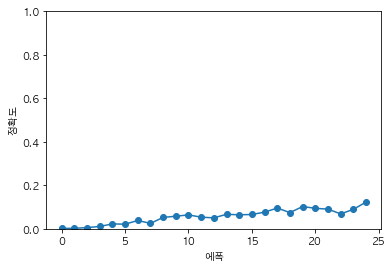

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정(뒤에서 다룰 예정) ==================================
is_reverse = False
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

model = Seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

## 7.4 seq2seq 개선

seq2seq 학습 속도 개선을 위한 두 가지 개선안  
1. 입력 데이터 반전
2. 엿보기(Peeky)

### 7.4.1 입력 데이터 반전(Reverse)

<img src='./img/7/reverse.png' width=500>

입력 데이터의 순서를 반전시키면 기울기 전파가 원활해지기 때문에   
어떤 문제를 다루느냐에 따라 다르지만, 대부분의 경우 더 좋은 결과가 나옴  
  
예를 들어 "나는 고양이로소이다"를 "I am a cat"으로 번역하는 문제에서,  
"나"라는 단어가 "I"로 변환되려면 나머지 단어들 분량의 LSTM 계층을 거쳐가야 함(거리가 멀다)  
  
만약 입력문을 반전시키면, "나"와 "I"는 바로 옆이 되어 역전파 시 기울기가 직접 전해짐  
따라서 학습 효율이 좋아짐

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.52
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 1[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 2[s] | 손실 1.91
| 에폭 1 |  반복 101 / 351 | 시간 2[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 3[s] | 손실 1.86
| 에폭 1 |  반복 141 / 351 | 시간 3[s] | 손실 1.84
| 에폭 1 |  반복 161 / 351 | 시간 4[s] | 손실 1.80
| 에폭 1 |  반복 181 / 351 | 시간 4[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 5[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 5[s] | 손실 1.77
| 에폭 1 |  반복 241 / 351 | 시간 6[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 6[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 7[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 7[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 8[s] | 손실 1.74
| 에폭 1 |  반복 341 / 351 | 시간 8[s] | 손실 1.73
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 582+84 
T 666 
☒ 1001
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 1001
---
Q 600+257
T 857 
☒ 1000
---
Q 761+292
T 1053
☒ 1000
---
Q 830+597
T 1427
☒ 1000
---
Q 26+838

| 에폭 8 |  반복 81 / 351 | 시간 2[s] | 손실 0.61
| 에폭 8 |  반복 101 / 351 | 시간 2[s] | 손실 0.61
| 에폭 8 |  반복 121 / 351 | 시간 3[s] | 손실 0.60
| 에폭 8 |  반복 141 / 351 | 시간 3[s] | 손실 0.60
| 에폭 8 |  반복 161 / 351 | 시간 4[s] | 손실 0.59
| 에폭 8 |  반복 181 / 351 | 시간 4[s] | 손실 0.58
| 에폭 8 |  반복 201 / 351 | 시간 5[s] | 손실 0.59
| 에폭 8 |  반복 221 / 351 | 시간 5[s] | 손실 0.60
| 에폭 8 |  반복 241 / 351 | 시간 6[s] | 손실 0.59
| 에폭 8 |  반복 261 / 351 | 시간 7[s] | 손실 0.58
| 에폭 8 |  반복 281 / 351 | 시간 7[s] | 손실 0.59
| 에폭 8 |  반복 301 / 351 | 시간 8[s] | 손실 0.58
| 에폭 8 |  반복 321 / 351 | 시간 8[s] | 손실 0.57
| 에폭 8 |  반복 341 / 351 | 시간 9[s] | 손실 0.57
Q 77+85  
T 162 
☒ 163 
---
Q 975+164
T 1139
☒ 1134
---
Q 582+84 
T 666 
☑ 666 
---
Q 8+155  
T 163 
☒ 162 
---
Q 367+55 
T 422 
☒ 423 
---
Q 600+257
T 857 
☒ 759 
---
Q 761+292
T 1053
☑ 1053
---
Q 830+597
T 1427
☒ 1431
---
Q 26+838 
T 864 
☒ 866 
---
Q 143+93 
T 236 
☒ 238 
---
검증 정확도 23.080%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.55
| 에폭 9 |  반복 21 / 351 | 시간 0[s] | 손실 0.56
| 에폭 9 |  반복 41 / 351

| 에폭 15 |  반복 101 / 351 | 시간 2[s] | 손실 0.38
| 에폭 15 |  반복 121 / 351 | 시간 3[s] | 손실 0.38
| 에폭 15 |  반복 141 / 351 | 시간 3[s] | 손실 0.38
| 에폭 15 |  반복 161 / 351 | 시간 4[s] | 손실 0.38
| 에폭 15 |  반복 181 / 351 | 시간 4[s] | 손실 0.38
| 에폭 15 |  반복 201 / 351 | 시간 5[s] | 손실 0.38
| 에폭 15 |  반복 221 / 351 | 시간 6[s] | 손실 0.39
| 에폭 15 |  반복 241 / 351 | 시간 6[s] | 손실 0.38
| 에폭 15 |  반복 261 / 351 | 시간 7[s] | 손실 0.37
| 에폭 15 |  반복 281 / 351 | 시간 7[s] | 손실 0.37
| 에폭 15 |  반복 301 / 351 | 시간 8[s] | 손실 0.39
| 에폭 15 |  반복 321 / 351 | 시간 8[s] | 손실 0.39
| 에폭 15 |  반복 341 / 351 | 시간 9[s] | 손실 0.37
Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☒ 1137
---
Q 582+84 
T 666 
☒ 667 
---
Q 8+155  
T 163 
☒ 164 
---
Q 367+55 
T 422 
☒ 420 
---
Q 600+257
T 857 
☒ 856 
---
Q 761+292
T 1053
☒ 1052
---
Q 830+597
T 1427
☒ 1431
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☒ 237 
---
검증 정확도 41.100%
| 에폭 16 |  반복 1 / 351 | 시간 0[s] | 손실 0.36
| 에폭 16 |  반복 21 / 351 | 시간 0[s] | 손실 0.36
| 에폭 16 |  반복 41 / 351 | 시간 1[s] | 손실 0.36
| 에폭 

| 에폭 22 |  반복 101 / 351 | 시간 2[s] | 손실 0.28
| 에폭 22 |  반복 121 / 351 | 시간 3[s] | 손실 0.29
| 에폭 22 |  반복 141 / 351 | 시간 3[s] | 손실 0.31
| 에폭 22 |  반복 161 / 351 | 시간 4[s] | 손실 0.31
| 에폭 22 |  반복 181 / 351 | 시간 4[s] | 손실 0.30
| 에폭 22 |  반복 201 / 351 | 시간 5[s] | 손실 0.28
| 에폭 22 |  반복 221 / 351 | 시간 5[s] | 손실 0.32
| 에폭 22 |  반복 241 / 351 | 시간 6[s] | 손실 0.33
| 에폭 22 |  반복 261 / 351 | 시간 7[s] | 손실 0.32
| 에폭 22 |  반복 281 / 351 | 시간 7[s] | 손실 0.31
| 에폭 22 |  반복 301 / 351 | 시간 8[s] | 손실 0.30
| 에폭 22 |  반복 321 / 351 | 시간 8[s] | 손실 0.29
| 에폭 22 |  반복 341 / 351 | 시간 9[s] | 손실 0.31
Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☑ 1139
---
Q 582+84 
T 666 
☑ 666 
---
Q 8+155  
T 163 
☑ 163 
---
Q 367+55 
T 422 
☒ 423 
---
Q 600+257
T 857 
☒ 856 
---
Q 761+292
T 1053
☑ 1053
---
Q 830+597
T 1427
☒ 1430
---
Q 26+838 
T 864 
☒ 865 
---
Q 143+93 
T 236 
☒ 238 
---
검증 정확도 47.740%
| 에폭 23 |  반복 1 / 351 | 시간 0[s] | 손실 0.31
| 에폭 23 |  반복 21 / 351 | 시간 0[s] | 손실 0.31
| 에폭 23 |  반복 41 / 351 | 시간 1[s] | 손실 0.28
| 에폭 

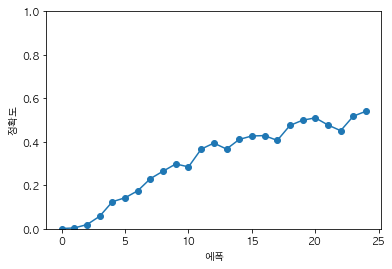

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq

# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 ================================================
is_reverse = True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

model = Seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

### 7.4.2 엿보기(Peeky)

<img src='./img/7/peeky_1.png' width=800>  
  
Encoder가 출력한 h 안에는 Decoder에게 필요한 정보가 모두 담겨져 있음  
위의 그림처럼 기존에 구현한 seq2seq는 최초 시각의 LSTM 계층만이 벡터 h를 이용함  

<img src='./img/7/peeky_2.png' width=800>  
  
하지만, 중요한 정보가 담긴 Encoder의 출력 h를 Decoder의 다른 계층과도 공유함으로서 모델을 더욱 개선할 수 있음  
  
위 그림과 같이 모든 시각의 Affine 계층과 LSTM 계층에 Encoder의 출력 h를 전해줌  
(이제 Affine 계층과 LSTM 계층에는 벡터 2개씩 입력됨)  
  
이 개선안은 인코딩 된 정보를 Decoder의 다른 계층에게도 전해주는 기법으로 달리보면 다른 계층도 인코딩된 정보를 '엿본다'라고 해석할 수 있음  
따라서 이 개선을 더한 Decoder를 'Peeky Decoder'라고 하며, Peeky Decoder를 이용하는 seq2seq를 'Peeky seq2seq'라고 함

In [40]:
from common.time_layers import *

class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f') # 크기 커짐
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f') # 크기 커짐
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None

    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H) # h를 시계열만큼 복제
        out = np.concatenate((hs, out), axis=2) # hs와 Embedding 계층의 출력 연결

        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2) # hs와 LSTM 계층의 출력을 연결

        score = self.affine.forward(out)
        self.cache = H
        return score

    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled


class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.57
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.48
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.20
| 에폭 1 |  반복 61 / 351 | 시간 1[s] | 손실 1.99
| 에폭 1 |  반복 81 / 351 | 시간 2[s] | 손실 1.89
| 에폭 1 |  반복 101 / 351 | 시간 2[s] | 손실 1.82
| 에폭 1 |  반복 121 / 351 | 시간 3[s] | 손실 1.82
| 에폭 1 |  반복 141 / 351 | 시간 4[s] | 손실 1.80
| 에폭 1 |  반복 161 / 351 | 시간 4[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 5[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 5[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 6[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 6[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 7[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 7[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 8[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 9[s] | 손실 1.73
| 에폭 1 |  반복 341 / 351 | 시간 9[s] | 손실 1.73
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1013
---
Q 582+84 
T 666 
☒ 102 
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 1023
---
Q 600+257
T 857 
☒ 1023
---
Q 761+292
T 1053
☒ 1023
---
Q 830+597
T 1427
☒ 1111
---
Q 26+838

| 에폭 8 |  반복 61 / 351 | 시간 1[s] | 손실 0.48
| 에폭 8 |  반복 81 / 351 | 시간 2[s] | 손실 0.47
| 에폭 8 |  반복 101 / 351 | 시간 3[s] | 손실 0.46
| 에폭 8 |  반복 121 / 351 | 시간 3[s] | 손실 0.46
| 에폭 8 |  반복 141 / 351 | 시간 4[s] | 손실 0.44
| 에폭 8 |  반복 161 / 351 | 시간 4[s] | 손실 0.41
| 에폭 8 |  반복 181 / 351 | 시간 5[s] | 손실 0.42
| 에폭 8 |  반복 201 / 351 | 시간 6[s] | 손실 0.41
| 에폭 8 |  반복 221 / 351 | 시간 6[s] | 손실 0.40
| 에폭 8 |  반복 241 / 351 | 시간 7[s] | 손실 0.39
| 에폭 8 |  반복 261 / 351 | 시간 7[s] | 손실 0.37
| 에폭 8 |  반복 281 / 351 | 시간 8[s] | 손실 0.36
| 에폭 8 |  반복 301 / 351 | 시간 9[s] | 손실 0.36
| 에폭 8 |  반복 321 / 351 | 시간 9[s] | 손실 0.35
| 에폭 8 |  반복 341 / 351 | 시간 10[s] | 손실 0.34
Q 77+85  
T 162 
☒ 161 
---
Q 975+164
T 1139
☑ 1139
---
Q 582+84 
T 666 
☒ 657 
---
Q 8+155  
T 163 
☒ 155 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☑ 857 
---
Q 761+292
T 1053
☑ 1053
---
Q 830+597
T 1427
☒ 1438
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☑ 236 
---
검증 정확도 65.060%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.32
| 에폭 9 |  반복 21 / 35

| 에폭 15 |  반복 81 / 351 | 시간 2[s] | 손실 0.04
| 에폭 15 |  반복 101 / 351 | 시간 3[s] | 손실 0.04
| 에폭 15 |  반복 121 / 351 | 시간 3[s] | 손실 0.03
| 에폭 15 |  반복 141 / 351 | 시간 4[s] | 손실 0.03
| 에폭 15 |  반복 161 / 351 | 시간 5[s] | 손실 0.04
| 에폭 15 |  반복 181 / 351 | 시간 5[s] | 손실 0.04
| 에폭 15 |  반복 201 / 351 | 시간 6[s] | 손실 0.04
| 에폭 15 |  반복 221 / 351 | 시간 6[s] | 손실 0.04
| 에폭 15 |  반복 241 / 351 | 시간 7[s] | 손실 0.04
| 에폭 15 |  반복 261 / 351 | 시간 8[s] | 손실 0.06
| 에폭 15 |  반복 281 / 351 | 시간 8[s] | 손실 0.06
| 에폭 15 |  반복 301 / 351 | 시간 9[s] | 손실 0.05
| 에폭 15 |  반복 321 / 351 | 시간 10[s] | 손실 0.06
| 에폭 15 |  반복 341 / 351 | 시간 10[s] | 손실 0.06
Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☑ 1139
---
Q 582+84 
T 666 
☑ 666 
---
Q 8+155  
T 163 
☑ 163 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☑ 857 
---
Q 761+292
T 1053
☑ 1053
---
Q 830+597
T 1427
☑ 1427
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☑ 236 
---
검증 정확도 94.040%
| 에폭 16 |  반복 1 / 351 | 시간 0[s] | 손실 0.04
| 에폭 16 |  반복 21 / 351 | 시간 0[s] | 손실 0.04
| 에

| 에폭 22 |  반복 81 / 351 | 시간 2[s] | 손실 0.02
| 에폭 22 |  반복 101 / 351 | 시간 3[s] | 손실 0.01
| 에폭 22 |  반복 121 / 351 | 시간 3[s] | 손실 0.01
| 에폭 22 |  반복 141 / 351 | 시간 4[s] | 손실 0.01
| 에폭 22 |  반복 161 / 351 | 시간 5[s] | 손실 0.01
| 에폭 22 |  반복 181 / 351 | 시간 5[s] | 손실 0.01
| 에폭 22 |  반복 201 / 351 | 시간 6[s] | 손실 0.01
| 에폭 22 |  반복 221 / 351 | 시간 6[s] | 손실 0.01
| 에폭 22 |  반복 241 / 351 | 시간 7[s] | 손실 0.01
| 에폭 22 |  반복 261 / 351 | 시간 8[s] | 손실 0.01
| 에폭 22 |  반복 281 / 351 | 시간 8[s] | 손실 0.01
| 에폭 22 |  반복 301 / 351 | 시간 9[s] | 손실 0.01
| 에폭 22 |  반복 321 / 351 | 시간 10[s] | 손실 0.02
| 에폭 22 |  반복 341 / 351 | 시간 10[s] | 손실 0.03
Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☑ 1139
---
Q 582+84 
T 666 
☑ 666 
---
Q 8+155  
T 163 
☑ 163 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☑ 857 
---
Q 761+292
T 1053
☑ 1053
---
Q 830+597
T 1427
☑ 1427
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☑ 236 
---
검증 정확도 95.800%
| 에폭 23 |  반복 1 / 351 | 시간 0[s] | 손실 0.03
| 에폭 23 |  반복 21 / 351 | 시간 0[s] | 손실 0.02
| 에

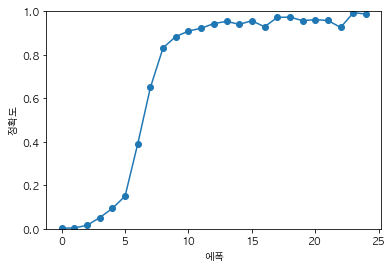

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq

# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 ================================================
is_reverse = True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 엿보기(Peeky) 설정 ===============================================
model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

Reverse|Peeky|accuracy
-------|-----|--------
X|X|약 12%
O|X|약 54%
O|O|약 98%  
  
Reverse와 Peeky, 두 가지 개선을 적용한 seq2seq의 정확도는 월등히 좋아졌음!

## 7.5 seq2seq를 이용하는 애플리케이션

seq2seq는 2개가 짝을 이루는 시계열 데이터를 다루는 문제에 이요할 수 있음  
자연어 외에도 음성이나 영상 등에 이용할 수 있음  

### 7.5.1 챗봇

### 7.5.2 알고리즘 학습

### 7.5.3 이미지 캡셔닝

<img src='./img/7/ImageCaptioning.png' width=800>
  
이미지 캡셔닝(Image Captioning) : 이미지를 문장으로 변환  
  
이미지의 인코딩을 CNN이 수행함  
CNN의 최종 출력인 특징 맵(feature map)은 3차원(높이 폭 채널)이므로 Decoder의 LSTM이 처리할 수 있도록 1차원으로 평탄화한 후 완전연결인 Affine 계층에서 변환함  
변환된 데이터를 Decoder에 전달하면 문장을 생성함